# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Заказчик предоставил набор фотографий людей с указанием возраста.

**План выполнения:**
- загрузить данные;
- провести исследовательский анализ набора фотографий;
- подготовить данные к обучению;
- обучить нейронную сеть и рассчитать её качество по метрике **MAE**. Требования Заказчика, чтобы **MAE не выше 8**.


## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [3]:
RANDOM_ST = 777

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
data_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_ST) 

Found 7591 validated image filenames.


Данные содержат 7591 фотографий.

In [5]:
labels.info()
labels.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


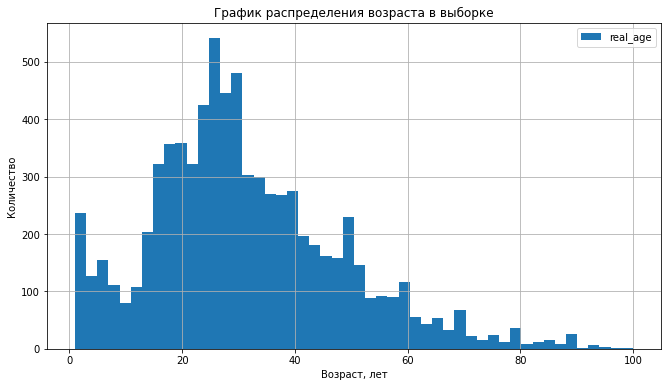

In [10]:
# гистограмма распределения значений признака "real_age" 
labels.plot(kind='hist', figsize=(11,6), bins=50, grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

- в данных **нет явных Nan-пропусков**;
- медиана и среднее значение **29** и **31 год** соответственно;
- в данных присутствуют фотографии детей **до 10 лет** и пожилых людей вплоть **до 100 лет**;
- межквартильный размах (средний разброс) в данных: **20 - 41 год**. Такая возрастная категория представлет **50%** всех данных;
- распределение возраста не является нормальным, имеет **длинный правый хвост** (скос данных в сторону больших предельных значений, представляющих собой небольшую частоту встречаемости);
- в графике распределения так же отмечается **небольшой пик** на значениях близких **к 1 году**. Такие данные врядли могут представлять ценность в рамках текущей задачи по выявлению возраста реальных покупателей магазина. Дети до **7-10 лет** врядли будут являться потенциальными покупателями.

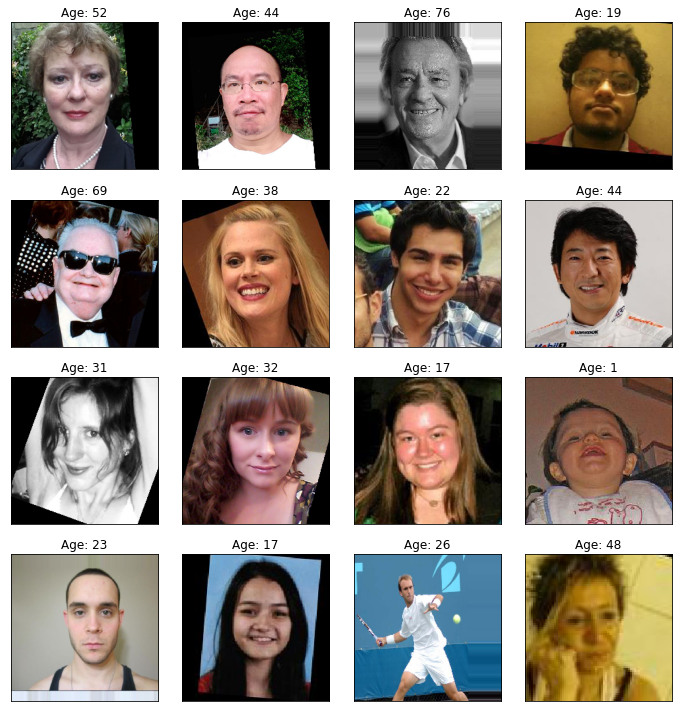

In [12]:
# вывод 15 фотографий
features, target = next(data_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- представленные фотографии содержат людей, разных национальностей;
- присутствуют фотографии человека в движении с дальним планом (например спортивные). На таких фото плохо различимо лицо, что ухудшит предсказательную способность модели;
- есть фотографии в плохом качестве (например размытость), что так же может ухудшить предсказательную способность модели;
- некоторые люди на фото могут носить темные очки, кепку, платок и т.д., которые частично или практически полностью закрывают лицо. В таком случае определение возраста человека практически невозможно;
- некоторые фотографии черно-белые или повернуты влево или вправо. Такое разнообразие может хорошо сказаться на обучении модели;
- скорее всего в данных так же присутствуют фотографии, где люди не смотрят в камеру, а смотрят например вбок. Это может повлиять на качество модели в худшую сторону.

**Общий вывод:**
1. В данных **нет явных Nan-пропусков**. Все фото размечены в допустимом диапазоне человеческого возраста (**1 - 100 лет**);
2. Данные представлены **небольшим количеством данных**, всего **7591 фотографий**. Предалагается аугментация данных или примененеие предобученного `бэкбона` например на наборе `ImageNet`;
3. Группы пользователей **в разной возрастной категории** представлены в данных **неравномерно**. Например люди в возрасте **старше 60 лет** в данных представлены **редко**, в отличие например от средней категории (**20 - 41 год**) или детей в возрасте **до 10 лет**. Модель скорее всего недостаточно обучится распознавать пожилых людей в диапазоне **60 - 100 лет**;
4. В данных присутствуют фото людей разного характера, которые в основном могут негативно повлиять на качество модели (**качество фото, позиция лица, дальний план, наличие дополнительных или посторонних предметов** и т.д.).  

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

**код из тренажёра:**
```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)
    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=777)

    return train_gen_flow

def load_test(path):

    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)
    labels = pd.read_csv(path + 'labels.csv')
    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=777)

    return val_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=8,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/8
178/178 - 46s - loss: 221.1396 - mean_absolute_error: 10.7199 - val_loss: 961.2540 - val_mean_absolute_error: 26.2791
Epoch 2/8
178/178 - 37s - loss: 58.9118 - mean_absolute_error: 5.8883 - val_loss: 879.5069 - val_mean_absolute_error: 24.8734
Epoch 3/8
178/178 - 37s - loss: 30.1986 - mean_absolute_error: 4.2531 - val_loss: 432.6785 - val_mean_absolute_error: 16.0186
Epoch 4/8
178/178 - 37s - loss: 19.4606 - mean_absolute_error: 3.4215 - val_loss: 128.4490 - val_mean_absolute_error: 8.8329
Epoch 5/8
178/178 - 37s - loss: 15.5202 - mean_absolute_error: 3.0259 - val_loss: 96.9733 - val_mean_absolute_error: 7.2931
Epoch 6/8
178/178 - 37s - loss: 13.2804 - mean_absolute_error: 2.7908 - val_loss: 72.6769 - val_mean_absolute_error: 6.4223
Epoch 7/8
178/178 - 37s - loss: 9.9992 - mean_absolute_error: 2.3968 - val_loss: 68.4887 - val_mean_absolute_error: 6.1843
Epoch 8/8
178/178 - 38s - loss: 9.8289 - mean_absolute_error: 2.3433 - val_loss: 76.7590 - val_mean_absolute_error: 6.4955

60/60 - 10s - loss: 76.7590 - mean_absolute_error: 6.4955
Test MAE: 6.4955

```

## Анализ обученной модели

В проекте была использована предварительно обученная на данных `ImageNet` модель на основе свёрточной сети **ResNet50**. 
Выходной модели был заменен на слой **GlobalAveragePooling2D** и полносвязный слой с одним нейроном (функция активации -**relu** в соотвествии с задачей **регрессии**). 

При обучении на 8 эпохах удалось достичь качества модели по метрике **MAE** - **6.496** на валидационной выборке, что лучше требуемого Заказчиком уровня (**не более 8**).

Характеристики модели и заданные параметры:
- `модель` - **ResNet50**, предобученная на **ImageNet**; 
- `аугментация` - **без аугментации**;
- размер `батча` - **32 изображения**;
- `learning_rate` оптимизатора `Adam` - **0.0004**;
- `количество эпох` - **8**. 